# Python4CLS database 102

Second part of the short introduction to interacting with CLS altimeter database system from Python.
In this section, we will cover extracting larger chunks of data, gridding, visualizing,...

In [16]:
# generic imports
import numpy as np
import os
import glob

# octant imports
from octant.data.orf import Orf
from octant.data.table import TableMeasure

# visu
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [17]:
%matplotlib inline

In [18]:
# get dates for one track
orf = Orf('T_AL')
track = orf.find_track_from_indices(10,1)

In [28]:
# extract the corresponding data
# you can pass a list of fields to the read_values() method,
# and these fields can be CLIPs

clip = 'ORBIT.ALTI - RANGE.ALTI - MEAN_SEA_SURFACE.MODEL.CNESCLS15'

fields_to_extract = ['LONGITUDE', 
                     'LATITUDE', 
                     clip]
table = TableMeasure('TABLE_T_AL_B_PEACHI')
data = table.read_values(fields_to_extract, track.first_date, track.last_date)
# the output of this method is a numpy ndarray object
print(type(data))
print(data[0])

<type 'numpy.ndarray'>
((23398, 20306, 584208), 96.448516, -81.499164, nan)


(-4, 0)

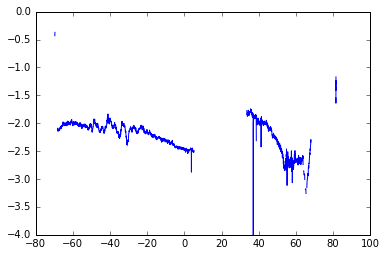

In [20]:
# lets uncorrected SLA as a function of latitude
plt.plot(data['LATITUDE'], data[clip])
plt.ylim(-4,0)

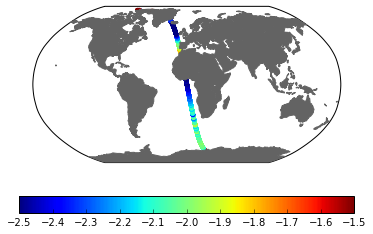

In [25]:
# we can even map it
m = Basemap(projection='robin',
            lon_0=0,
            resolution='c')
m.drawcoastlines(color='#636363')
m.fillcontinents(color='#636363')
sc=m.scatter(data['LONGITUDE'],
              data['LATITUDE'],
                c=data[clip],
             linewidths=0.,
              latlon=True,
            vmin=-2.5, vmax=-1.5)
cbar = plt.colorbar(sc, orientation='horizontal')

## gridding

In [29]:
# to do that, let's extract a full cycle
# first let's find the time limits
first_date = orf.find_track_from_indices(10,1).first_date
last_date = orf.find_track_from_indices(10,1002).last_date

In [30]:
# and extract the data, 
# here we convert to a pandas.DataFrame object but that is not absolutely necessary
data = table.read_values(fields_to_extract, first_date, last_date)

In [34]:
# usually i would convert the ndarray to a pandas DataFrame, but panads is not available here
mask = data[clip] != data[clip]
print(np.shape(mask))
lons = np.ma.array(data['LONGITUDE'], mask=mask).compressed()
lats = np.ma.array(data['LATITUDE'], mask=mask).compressed()
sla = np.ma.array(data[clip], mask=mask).compressed()
print(np.shape(sla))
print(np.shape(lons))

(2801408,)
(1668196,)
(1668196,)


In [52]:
# lets say we want to grid data onto a regular (in degrees) grid
grid_step = 2
grid_lons = np.arange(0,360,grid_step)
grid_lats = np.arange(-90,90,grid_step)

In [53]:
# get index of lon/lat
i_lat = ((lats - grid_lats[0])/grid_step).astype(int)
i_lon = ((lons - grid_lons[0])/grid_step).astype(int)

# and create a unique index
index = i_lon*len(grid_lats) + i_lat

# bin for number of obs
box_number = np.bincount(index, minlength=len(grid_lons)*len(grid_lats)).reshape(len(grid_lons), len(grid_lats)).astype(float)

# bin for sum of obs
box_sum = np.bincount(index, sla, minlength=len(grid_lons)*len(grid_lats)).reshape(len(grid_lons), len(grid_lats)).astype(float)

# estimate the mean
box_mean = np.empty(np.shape(box_number))
box_mean[:] = np.nan
not_zero = box_number > 0
box_mean[not_zero] = np.divide(box_sum[not_zero], box_number[not_zero])

# converting to a masked array (for convenience mainly)
box_mean = np.ma.array(box_mean, mask=~not_zero)
print(np.shape(box_mean))

(180, 90)


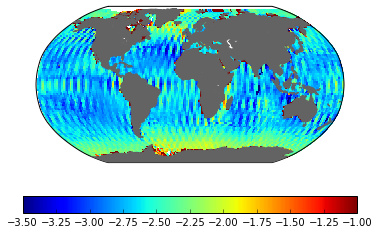

In [54]:
# create a mesh from lons & lats
llons, llats = np.meshgrid(grid_lons, grid_lats)
m = Basemap(projection='robin',
            lon_0=0,
            resolution='c')
m.drawcoastlines(color='#636363')
m.fillcontinents(color='#636363')
sc=m.pcolormesh(llons,
              llats,
             box_mean.T,
               latlon=True,
               vmin=-3.5, vmax=-1)
cbar = plt.colorbar(sc, orientation='horizontal')